In [45]:
import pandas as pd
import numpy as np
from io import StringIO
import re

import seaborn as sns
import matplotlib.pyplot as plt

import random
from datetime import datetime
from datetime import timedelta
import time
%matplotlib inline

import plotly
from plotly.offline import plot
import plotly.graph_objs as go
import plotly.express as px

In [46]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Q4. Optimizing memory is more important for longer running jobs then shorter running jobs as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group? (i.e., what is the weighted average of memory usage vs. requested memory for each group?)

To do:  
-group data frame by user groups  
-understand sequential jobid numbering (and if that is a proxy for arrays)  
-create new columns for weighted average requested and weighted average used per group  
-focus on "production" partitions (but if there's time, look at others as well)  
-compare required time to used time and completed jobs to failed jobs; is there a buffer around run time? does the job cancel the second that used time exceeded required time?  

In [3]:
accre = pd.read_csv('../data/accre-jobs-2020-clean.csv')

In [4]:
accre.head()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,122880,Mn,5120.0,M,65973,2748.875000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:28,1188028.0
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,122880,Mn,5120.0,M,67181,2799.208333,1123200.0,18:00:00,1188000.0,1036800.0,14:50:56,1090256.0
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,0:0,COMPLETED,cn1464,122880,Mn,5120.0,M,69111,2879.625000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:20,1188020.0
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,0:0,COMPLETED,cn1473,122880,Mn,5120.0,M,65317,2721.541667,1123200.0,18:00:00,1188000.0,1036800.0,03:50:32,1050632.0
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,0:0,COMPLETED,cn1440,122880,Mn,5120.0,M,65876,2744.833333,1123200.0,18:00:00,1188000.0,1123200.0,18:00:03,1188003.0


In [5]:
accre.tail()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
3816285,24173815_8,portabella,vennie,32768Mn,30042.68M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,30042,15021.0,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816286,24173815_9,portabella,vennie,32768Mn,31067.75M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,31067,15533.5,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816287,24173815_10,portabella,vennie,32768Mn,21207.96M,1-00:00:00,00:01:40,1,2,production,0:0,COMPLETED,cn368,32768,Mn,16384.0,M,21207,10603.5,86400.0,00:00:00,86400.0,0.0,00:01:40,100.0
3816288,24173817,boysenberries,hortensia,100000Mn,0,1-00:00:00,00:03:05,1,8,production,0:0,RUNNING,cn1509,100000,Mn,12500.0,NaN,0,0.0,86400.0,00:00:00,86400.0,0.0,00:03:05,185.0
3816289,24173866,horseradish,ariane,20480Mn,0,05:00:00,00:02:05,1,1,production,0:0,RUNNING,cn1131,20480,Mn,20480.0,NaN,0,0.0,0.0,05:00:00,18000.0,0.0,00:02:05,125.0


Examine 'production' partitions only.

In [ ]:
# accre_prod_only = accre[accre.PARTITION == 'production']
# accre_prod_only

In [ ]:
# accre_prod_cplt_only = accre_prod_only[accre.STATE == 'COMPLETED']

In [6]:
#accre_mem_use = accre[(accre['EXITCODE'] == '0:0') & (accre['STATE'] == 'COMPLETED') & (accre['PARTITION'] == 'production') & (accre['USEDMEM'] != 0)]
#accre_mem_use
accre_mem_use = accre[(accre['EXITCODE'] == '0:0') & (accre['STATE'] == 'COMPLETED') & (accre['PARTITION'] == 'production') & (accre['USEDMEM_PER_CORE'] != 0)]
accre_mem_use

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQMEM_NO,REQMEM_TYPE,REQMEM_PER_CORE,USEDMEM_TYPE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,122880,Mn,5120.0,M,65973,2748.875000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:28,1188028.0
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,122880,Mn,5120.0,M,67181,2799.208333,1123200.0,18:00:00,1188000.0,1036800.0,14:50:56,1090256.0
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,0:0,COMPLETED,cn1464,122880,Mn,5120.0,M,69111,2879.625000,1123200.0,18:00:00,1188000.0,1123200.0,18:00:20,1188020.0
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,0:0,COMPLETED,cn1473,122880,Mn,5120.0,M,65317,2721.541667,1123200.0,18:00:00,1188000.0,1036800.0,03:50:32,1050632.0
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,0:0,COMPLETED,cn1440,122880,Mn,5120.0,M,65876,2744.833333,1123200.0,18:00:00,1188000.0,1123200.0,18:00:03,1188003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816283,24173815_6,portabella,vennie,32768Mn,23269.08M,1-00:00:00,00:01:36,1,2,production,0:0,COMPLETED,cn432,32768,Mn,16384.0,M,23269,11634.500000,86400.0,00:00:00,86400.0,0.0,00:01:36,96.0
3816284,24173815_7,portabella,vennie,32768Mn,20879.81M,1-00:00:00,00:01:37,1,2,production,0:0,COMPLETED,cn440,32768,Mn,16384.0,M,20879,10439.500000,86400.0,00:00:00,86400.0,0.0,00:01:37,97.0
3816285,24173815_8,portabella,vennie,32768Mn,30042.68M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,30042,15021.000000,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0
3816286,24173815_9,portabella,vennie,32768Mn,31067.75M,1-00:00:00,00:02:27,1,2,production,0:0,COMPLETED,cn312,32768,Mn,16384.0,M,31067,15533.500000,86400.0,00:00:00,86400.0,0.0,00:02:27,147.0


In [7]:
# df1 = df[['a','d']]
# accre_prod_coi = accre_prod_cplt_only[['JOBID', 'ACCOUNT', 'USER', 'STATE', 'REQMEM_PER_CORE', 'USEDMEM_PER_CORE', 'REQTIME_SEC', 'USEDTIME_SEC', 'NODES', 'CPUS', 'PARTITION', 'NODELIST']]

Group DataFrame by account and then user

In [8]:
accre_q4_byacct = accre_mem_use.groupby('ACCOUNT')

In [ ]:
# code to print the first entry in each of the groups
accre_q4_byacct.first()

In [9]:
type(accre_q4_byacct)

pandas.core.groupby.generic.DataFrameGroupBy

In [ ]:
#accre_q4_groups = accre_prod_coi.groupby(['ACCOUNT', 'USER'])
#accre_q4_groups.head()

In [10]:
accre_q4_byacct.ACCOUNT.count()

ACCOUNT
alkmene           15488
almonds            1181
amaranth           2606
angelys             205
anise               425
antares             119
arra                 59
atemoyas          22054
baby                435
baking              385
bay                 172
bell                  8
belle              5618
bertanne           4379
bibb                 92
blackberries       1233
bon                 898
boysenberries     27905
brazilnuts          678
broccoli             18
bulk              49069
bunch             88764
burro              1278
cactus              174
cantared           2304
carambola           369
carrot           179720
casaba           104022
celery            14506
cep              462929
chasselas          1309
chayote              31
chickpeas         10480
chipilin            252
cinnabar             92
clara              6305
cms              412817
cms_lowprio      105836
cmsadmin          23369
cocktail              4
concord             526
conferen

In [ ]:
#accre_q4_groups.JOBID.nunique()

In [11]:
accre_mem_coi = accre_mem_use[['JOBID', 'ACCOUNT', 'USER', 'STATE', 'REQMEM_PER_CORE', 'USEDMEM_PER_CORE', 'REQTIME_SEC', 'USEDTIME_SEC', 'NODES', 'CPUS', 'PARTITION', 'NODELIST']]
accre_mem_coi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2708457 entries, 0 to 3816287
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   JOBID             object 
 1   ACCOUNT           object 
 2   USER              object 
 3   STATE             object 
 4   REQMEM_PER_CORE   float64
 5   USEDMEM_PER_CORE  float64
 6   REQTIME_SEC       float64
 7   USEDTIME_SEC      float64
 8   NODES             int64  
 9   CPUS              int64  
 10  PARTITION         object 
 11  NODELIST          object 
dtypes: float64(4), int64(2), object(6)
memory usage: 268.6+ MB


In [12]:
accre_mem_use['USEDMEM*TIMESEC'] = accre_mem_use['USEDMEM_PER_CORE']*accre_mem_use['USEDTIME_SEC']
accre_mem_use['REQMEM*TIMESEC'] = accre_mem_use['REQMEM_PER_CORE']*accre_mem_use['USEDTIME_SEC']

<ipython-input-12-d8424111ce68>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-d8424111ce68>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
accre_mem_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2708457 entries, 0 to 3816287
Data columns (total 27 columns):
 #   Column            Dtype  
---  ------            -----  
 0   JOBID             object 
 1   ACCOUNT           object 
 2   USER              object 
 3   REQMEM            object 
 4   USEDMEM           object 
 5   REQTIME           object 
 6   USEDTIME          object 
 7   NODES             int64  
 8   CPUS              int64  
 9   PARTITION         object 
 10  EXITCODE          object 
 11  STATE             object 
 12  NODELIST          object 
 13  REQMEM_NO         int64  
 14  REQMEM_TYPE       object 
 15  REQMEM_PER_CORE   float64
 16  USEDMEM_TYPE      object 
 17  USEDMEM_NO        int64  
 18  USEDMEM_PER_CORE  float64
 19  REQTIME_DAY_SEC   float64
 20  REQTIME_T         object 
 21  REQTIME_SEC       float64
 22  USEDTIME_DAY_SEC  float64
 23  USEDTIME_T        object 
 24  USEDTIME_SEC      float64
 25  USEDMEM*TIMESEC   float64
 26  REQMEM*TIMESEC

In [14]:
accre_acct_user = accre_mem_use.groupby(['ACCOUNT', 'USER']).sum().reset_index()
# ['USEDMEM*TIMESEC', 'REQMEM*TIMESEC']

In [15]:
accre_acct_user

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC
0,alkmene,abigail,19,91,372736,6.724267e+04,7367,1.203208e+03,604800.0,673200.0,86400.0,174098.0,4.445541e+07,1.362612e+09
1,alkmene,cleve,12,60,786432,1.720320e+05,9578,1.993875e+03,1900800.0,1915200.0,1900800.0,1915315.0,3.436870e+08,2.843116e+10
2,alkmene,marci,118,399,6932218,1.552719e+06,1972479,4.358358e+05,777600.0,3661200.0,0.0,839020.0,4.122353e+09,1.318533e+10
3,alkmene,vaughn,137,2286,696248,4.551794e+04,485046,2.871492e+04,0.0,10156800.0,0.0,5891190.0,1.274627e+09,1.842803e+09
4,alkmene,velvet,15247,121499,125630464,1.605094e+07,44062245,5.519795e+06,3888000.0,58786200.0,0.0,26480394.0,9.740737e+09,3.010888e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,wood,penelope,7,84,20480,1.706667e+03,7983,6.652500e+02,1382400.0,1382400.0,777600.0,978304.0,7.644648e+07,2.213825e+08
544,wood,shea,178,1424,4374528,5.468160e+05,407391,5.092388e+04,0.0,2008800.0,0.0,1064859.0,4.246257e+08,3.271247e+09
545,wood,tod,13,104,319488,3.993600e+04,35912,4.489000e+03,0.0,655200.0,0.0,45891.0,2.626501e+07,1.409772e+08
546,yu,mozelle,81,130,1389574,7.710780e+05,482473,2.604078e+05,0.0,639360.0,0.0,162089.0,6.042196e+08,1.913688e+09


In [ ]:
#accre_acct_user = accre_acct_user[['ACCOUNT', 'USER', 'USEDMEM*TIMESEC', 'REQMEM*TIMESEC', 'USEDTIME_SEC']]

In [16]:
accre_acct_user['%USAGE'] = accre_acct_user['USEDMEM*TIMESEC']/accre_acct_user['REQMEM*TIMESEC'] * 100

In [18]:
accre_acct_user

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
0,alkmene,abigail,19,91,372736,6.724267e+04,7367,1.203208e+03,604800.0,673200.0,86400.0,174098.0,4.445541e+07,1.362612e+09,3.262513
1,alkmene,cleve,12,60,786432,1.720320e+05,9578,1.993875e+03,1900800.0,1915200.0,1900800.0,1915315.0,3.436870e+08,2.843116e+10,1.208839
2,alkmene,marci,118,399,6932218,1.552719e+06,1972479,4.358358e+05,777600.0,3661200.0,0.0,839020.0,4.122353e+09,1.318533e+10,31.264700
3,alkmene,vaughn,137,2286,696248,4.551794e+04,485046,2.871492e+04,0.0,10156800.0,0.0,5891190.0,1.274627e+09,1.842803e+09,69.167823
4,alkmene,velvet,15247,121499,125630464,1.605094e+07,44062245,5.519795e+06,3888000.0,58786200.0,0.0,26480394.0,9.740737e+09,3.010888e+10,32.351711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,wood,penelope,7,84,20480,1.706667e+03,7983,6.652500e+02,1382400.0,1382400.0,777600.0,978304.0,7.644648e+07,2.213825e+08,34.531405
544,wood,shea,178,1424,4374528,5.468160e+05,407391,5.092388e+04,0.0,2008800.0,0.0,1064859.0,4.246257e+08,3.271247e+09,12.980546
545,wood,tod,13,104,319488,3.993600e+04,35912,4.489000e+03,0.0,655200.0,0.0,45891.0,2.626501e+07,1.409772e+08,18.630686
546,yu,mozelle,81,130,1389574,7.710780e+05,482473,2.604078e+05,0.0,639360.0,0.0,162089.0,6.042196e+08,1.913688e+09,31.573561


In [40]:
accre_acct_user.ACCOUNT.nunique()

132

In [ ]:
#create a stacked bar chart for highly efficient accounts and highly inefficient accounts

In [19]:
accre_acct_user_low10 = accre_acct_user.sort_values(['%USAGE'], ascending=True).head(10)
accre_acct_user_low10

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
95,blackberries,parker,1,24,65536,2.730667e+03,6,0.250000,172800.0,172800.0,0.0,451.0,1.127500e+02,1.231531e+06,0.009155
452,sharlin,orah,438,585,11501568,8.701659e+06,1399,1356.785714,14860800.0,32940000.0,518400.0,3506709.0,1.430516e+07,6.929455e+10,0.020644
44,bibb,parrish,4,4,40960,4.096000e+04,146,146.000000,86400.0,136800.0,0.0,26797.0,7.025800e+04,3.242803e+08,0.021666
149,cantared,merwin,89,89,712000,7.120000e+05,191,191.000000,76896000.0,76896000.0,10022400.0,13371134.0,2.899532e+07,1.069691e+11,0.027106
270,galangal,belia,1,16,126976,7.936000e+03,44,2.750000,86400.0,86400.0,86400.0,86409.0,2.376248e+05,6.857418e+08,0.034652
374,pasilla,booker,330,3872,7106560,5.788160e+05,5920,372.750000,30931200.0,31912500.0,3974400.0,5838241.0,1.342093e+07,3.045818e+10,0.044063
27,bay,annabel,82,162,2023424,1.040384e+06,30506,4075.375000,1814400.0,3412800.0,1123200.0,2343556.0,1.294213e+07,2.915197e+10,0.044395
233,cocktail,rollo,4,4,40960,4.096000e+04,223,223.000000,2419200.0,2419200.0,0.0,138504.0,1.024250e+06,1.418281e+09,0.072218
375,pasilla,davon,3,3,15360,1.536000e+04,11,11.000000,518400.0,518400.0,172800.0,198768.0,7.894230e+05,1.017692e+09,0.077570
145,cantared,harm,17,272,17408,1.740800e+04,265,16.562500,3715200.0,4046400.0,1987200.0,2262809.0,2.488509e+06,2.317116e+09,0.107397


In [21]:
accre_acct_user_top10 = accre_acct_user.sort_values(['%USAGE'], ascending=True).tail(11)
accre_acct_user_top10

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
43,bibb,mercedes,45,93,1612800,7.526400e+05,552105,2.250470e+05,2332800.0,2804700.0,604800.0,821659.0,7.980134e+09,9.242342e+09,86.343200
407,regal,charlotte,20,40,655360,3.276800e+05,541450,2.707250e+05,3456000.0,3456000.0,0.0,1163240.0,1.654979e+10,1.905852e+10,86.836693
411,retailer,aleck,5838,14041,182523904,7.507644e+07,145523060,6.036975e+07,4665600.0,111952800.0,86400.0,46461498.0,5.289728e+11,6.088689e+11,86.877949
278,galia,lenwood,777,7069,14340192,4.198192e+06,9975980,3.081953e+06,134611200.0,134632800.0,12873600.0,21280204.0,4.659565e+10,5.283772e+10,88.186337
512,treviso,brandon,19,19,311296,3.112960e+05,294673,2.946730e+05,0.0,1231200.0,0.0,163848.0,2.543242e+09,2.684486e+09,94.738510
176,cep,aileen,837,837,1714176,1.714176e+06,968732,9.687320e+05,224467200.0,224467200.0,53222400.0,64173838.0,1.272369e+11,1.314280e+11,96.811117
396,portabella,abril,1,1,1024,1.024000e+03,1022,1.022000e+03,0.0,3600.0,0.0,3621.0,3.700662e+06,3.707904e+06,99.804688
464,st,demarcus,3,3,12288,1.228800e+04,12229,1.222900e+04,1900800.0,2001600.0,172800.0,309547.0,1.266831e+09,1.267905e+09,99.915309
246,crowns,tena,886,11,56320,5.632000e+04,101348,1.013480e+05,1296000.0,1368000.0,259200.0,681707.0,9.624251e+09,3.490340e+09,275.739660
247,crowns,wilhelmina,200,2,10240,1.024000e+04,29094,2.909400e+04,432000.0,432000.0,0.0,180.0,2.966292e+06,9.216000e+05,321.863281


In [22]:
accre_acct_user_top10 = accre_acct_user_top10.loc[[43, 407, 411, 278, 512, 176, 396, 464, 246, 247]]
accre_acct_user_top10

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
43,bibb,mercedes,45,93,1612800,7.526400e+05,552105,2.250470e+05,2332800.0,2804700.0,604800.0,821659.0,7.980134e+09,9.242342e+09,86.343200
407,regal,charlotte,20,40,655360,3.276800e+05,541450,2.707250e+05,3456000.0,3456000.0,0.0,1163240.0,1.654979e+10,1.905852e+10,86.836693
411,retailer,aleck,5838,14041,182523904,7.507644e+07,145523060,6.036975e+07,4665600.0,111952800.0,86400.0,46461498.0,5.289728e+11,6.088689e+11,86.877949
278,galia,lenwood,777,7069,14340192,4.198192e+06,9975980,3.081953e+06,134611200.0,134632800.0,12873600.0,21280204.0,4.659565e+10,5.283772e+10,88.186337
512,treviso,brandon,19,19,311296,3.112960e+05,294673,2.946730e+05,0.0,1231200.0,0.0,163848.0,2.543242e+09,2.684486e+09,94.738510
176,cep,aileen,837,837,1714176,1.714176e+06,968732,9.687320e+05,224467200.0,224467200.0,53222400.0,64173838.0,1.272369e+11,1.314280e+11,96.811117
396,portabella,abril,1,1,1024,1.024000e+03,1022,1.022000e+03,0.0,3600.0,0.0,3621.0,3.700662e+06,3.707904e+06,99.804688
464,st,demarcus,3,3,12288,1.228800e+04,12229,1.222900e+04,1900800.0,2001600.0,172800.0,309547.0,1.266831e+09,1.267905e+09,99.915309
246,crowns,tena,886,11,56320,5.632000e+04,101348,1.013480e+05,1296000.0,1368000.0,259200.0,681707.0,9.624251e+09,3.490340e+09,275.739660
247,crowns,wilhelmina,200,2,10240,1.024000e+04,29094,2.909400e+04,432000.0,432000.0,0.0,180.0,2.966292e+06,9.216000e+05,321.863281


In [ ]:
fontsize = 16

plt.figure(figsize = (12,7))
sns.barplot(x = 'ACCOUNT', y = '%USAGE', data = accre_acct_user_low10, hue = 'USER')

plt.xticks(fontsize = fontsize)
plt.xlabel('Accounts by User', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.ylabel('Average % Used Memory of Memory Requested', fontsize = fontsize)
plt.title('% Memory Used of Memory Requested by Least Efficient Users within Each Account', fontsize = fontsize, fontweight = 'bold')
plt.legend(loc = 'upper left', fontsize = fontsize - 5);

In [ ]:
fontsize = 16

plt.figure(figsize = (12,7))
sns.barplot(x = 'ACCOUNT', y = '%USAGE', data = accre_acct_user_top10, hue = 'USER')

plt.xticks(fontsize = fontsize)
plt.xlabel('Accounts by User', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.ylabel('Average % Used Memory of Memory Requested', fontsize = fontsize)
plt.title('% Memory Used of Memory Requested by Most Efficient Users within Each Account', fontsize = fontsize, fontweight = 'bold')
plt.legend(loc = 'upper left', fontsize = fontsize - 5);

In [ ]:
#accre_acct_avg

In [ ]:
#var1 = accre_prod_coi.groupby('ACCOUNT').JOBID.nunique()
#var1

In [ ]:
#accre_acct_avg['ACCT_%_AVG'] = (accre_acct_avg['USEDMEM*TIMESEC']/accre_acct_avg['REQMEM*TIMESEC']) / var1 * 100
#accre_acct_avg

In [23]:
accre_acct = accre_mem_use.groupby('ACCOUNT').sum().reset_index()

In [24]:
accre_acct

,ACCOUNT,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC
0,alkmene,15533,124335,134418098,1.788846e+07,46536715,5.987543e+06,7.171200e+06,7.519260e+07,1.987200e+06,3.530002e+07,1.552586e+10,7.493078e+10
1,almonds,1181,4487,9011456,3.518677e+06,2567816,6.482458e+05,1.987200e+06,1.615320e+07,5.184000e+05,1.734392e+06,1.283370e+09,8.612110e+09
2,amaranth,2606,2914,21348352,2.113809e+07,731358,7.017983e+05,1.205453e+09,1.205454e+09,9.676800e+06,9.298447e+07,3.117560e+10,7.579918e+11
3,angelys,19992,205,222208,2.222080e+05,2495,2.495000e+03,4.320000e+05,5.133600e+05,4.320000e+05,4.487880e+05,4.614436e+07,1.786872e+09
4,anise,425,1670,30887657,7.143998e+06,10456933,2.499416e+06,1.468800e+07,2.973780e+07,7.171200e+06,1.452365e+07,1.139301e+11,2.301269e+11
5,antares,119,119,365568,3.655680e+05,242551,2.425510e+05,1.028160e+07,1.028160e+07,0.000000e+00,4.218010e+05,8.725253e+08,1.295773e+09
6,arra,282,479,2516992,1.807172e+06,1366660,2.118391e+05,5.184000e+05,2.139300e+06,8.640000e+04,6.216460e+05,2.040521e+09,1.208567e+10
7,atemoyas,22054,234109,236509184,2.386626e+07,17132737,1.381348e+06,1.377130e+09,1.583525e+09,1.002240e+07,5.529408e+07,1.030930e+10,6.585370e+10
8,baby,435,2175,43500000,8.700000e+06,3776754,7.553508e+05,4.675968e+08,4.675968e+08,8.035200e+06,1.414328e+07,4.124594e+10,2.828655e+11
9,baking,385,3529,49373184,6.194713e+06,15535274,1.873561e+06,9.106560e+07,9.632820e+07,4.527360e+07,5.304046e+07,3.770049e+11,8.348070e+11


In [25]:
accre_acct['%USAGE'] = accre_acct['USEDMEM*TIMESEC']/accre_acct_user['REQMEM*TIMESEC'] * 100

In [26]:
accre_acct 

,ACCOUNT,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
0,alkmene,15533,124335,134418098,1.788846e+07,46536715,5.987543e+06,7.171200e+06,7.519260e+07,1.987200e+06,3.530002e+07,1.552586e+10,7.493078e+10,1.139419e+03
1,almonds,1181,4487,9011456,3.518677e+06,2567816,6.482458e+05,1.987200e+06,1.615320e+07,5.184000e+05,1.734392e+06,1.283370e+09,8.612110e+09,4.513954e+00
2,amaranth,2606,2914,21348352,2.113809e+07,731358,7.017983e+05,1.205453e+09,1.205454e+09,9.676800e+06,9.298447e+07,3.117560e+10,7.579918e+11,2.364416e+02
3,angelys,19992,205,222208,2.222080e+05,2495,2.495000e+03,4.320000e+05,5.133600e+05,4.320000e+05,4.487880e+05,4.614436e+07,1.786872e+09,2.504031e+00
4,anise,425,1670,30887657,7.143998e+06,10456933,2.499416e+06,1.468800e+07,2.973780e+07,7.171200e+06,1.452365e+07,1.139301e+11,2.301269e+11,3.783935e+02
5,antares,119,119,365568,3.655680e+05,242551,2.425510e+05,1.028160e+07,1.028160e+07,0.000000e+00,4.218010e+05,8.725253e+08,1.295773e+09,1.013138e+01
6,arra,282,479,2516992,1.807172e+06,1366660,2.118391e+05,5.184000e+05,2.139300e+06,8.640000e+04,6.216460e+05,2.040521e+09,1.208567e+10,2.692009e-01
7,atemoyas,22054,234109,236509184,2.386626e+07,17132737,1.381348e+06,1.377130e+09,1.583525e+09,1.002240e+07,5.529408e+07,1.030930e+10,6.585370e+10,5.825285e+02
8,baby,435,2175,43500000,8.700000e+06,3776754,7.553508e+05,4.675968e+08,4.675968e+08,8.035200e+06,1.414328e+07,4.124594e+10,2.828655e+11,1.678302e+07
9,baking,385,3529,49373184,6.194713e+06,15535274,1.873561e+06,9.106560e+07,9.632820e+07,4.527360e+07,5.304046e+07,3.770049e+11,8.348070e+11,1.173634e+07


In [34]:
# highly efficient accounts
accre_acct_he = accre_acct.loc[accre_acct['%USAGE'] <= 100]
accre_acct_he

,ACCOUNT,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
1,almonds,1181,4487,9011456,3.518677e+06,2567816,6.482458e+05,1987200.0,1.615320e+07,518400.0,1734392.0,1.283370e+09,8.612110e+09,4.513954
3,angelys,19992,205,222208,2.222080e+05,2495,2.495000e+03,432000.0,5.133600e+05,432000.0,448788.0,4.614436e+07,1.786872e+09,2.504031
5,antares,119,119,365568,3.655680e+05,242551,2.425510e+05,10281600.0,1.028160e+07,0.0,421801.0,8.725253e+08,1.295773e+09,10.131376
6,arra,282,479,2516992,1.807172e+06,1366660,2.118391e+05,518400.0,2.139300e+06,86400.0,621646.0,2.040521e+09,1.208567e+10,0.269201
11,bell,8,71,1208320,1.484800e+05,285302,2.856988e+04,3715200.0,3.715200e+06,1641600.0,1831555.0,2.343042e+09,3.691583e+10,9.669131
14,bibb,92,140,2024448,1.164288e+06,612567,2.855090e+05,4233600.0,6.639900e+06,1209600.0,1625772.0,1.170788e+10,1.536311e+10,9.463501
22,burro,1685,3058,8371200,9.294157e+06,2922704,8.444934e+05,140313600.0,1.537974e+08,17452800.0,25554901.0,5.127552e+10,2.264741e+11,12.999344
23,cactus,174,182,1441792,1.380352e+06,432349,4.135548e+05,3196800.0,3.744000e+06,3024000.0,3158248.0,1.224586e+10,2.792554e+10,19.505953
28,celery,14506,14593,4757426,4.209475e+06,881586,8.799545e+05,1987200.0,7.026720e+06,172800.0,1255898.0,8.990478e+07,4.719919e+09,1.115166
31,chayote,32,124,477184,4.771840e+05,28640,7.160000e+03,0.0,4.794000e+05,0.0,147026.0,3.304345e+07,2.366910e+09,0.047717


In [80]:
accre_acct_he = accre_acct_he.sort_values(['%USAGE'], ascending=False).head(6)
accre_acct_he

,ACCOUNT,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
57,horn,193,1519,1927305,4.883662e+05,279868,62938.458333,116985600.0,121501800.0,1382400.0,3788623.0,8.752519e+08,9.598608e+09,98.786941
116,sugranineteen,863,1535,8853504,5.825024e+06,823333,349721.000000,233193600.0,248364000.0,141696000.0,159851055.0,8.177477e+10,6.556170e+11,96.999927
104,romanesco,1,1,4096,4.096000e+03,7,7.000000,345600.0,345600.0,345600.0,345609.0,2.419263e+06,1.415614e+09,79.708553
48,fiddlehead,31,222,1998848,3.031040e+05,92248,19454.000000,4320000.0,4694400.0,1296000.0,1725509.0,6.145264e+08,1.458996e+10,70.138525
71,lollo,39,79,1320960,5.017600e+05,82600,79876.000000,4147200.0,5059800.0,1123200.0,2448516.0,2.774968e+09,3.385502e+10,57.657721
33,chipilin,252,823,2000416,8.846760e+05,987697,424734.250000,304819200.0,304819200.0,18230400.0,30577547.0,7.460045e+10,1.683979e+11,56.881116


6 accounts seem to be highly efficient on average when using job runtimes as a weight. The names of these accounts (from most to least efficient) are:  
1. horn (98.79%)  
2. sugranineteen (97.00%)  
3. romanesco (79.71%)  
4. fiddlehead (70.14%)  
5. lollo (57.66%)  
6. chipilin (56.88%)  

In [27]:
# least efficient accounts (using significantly less memory than they're requesting)
accre_acct_low10 = accre_acct.sort_values(['%USAGE'], ascending=True).head(10)
accre_acct_low10

,ACCOUNT,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
81,mung,1,1,4096,4.096000e+03,45,45.000000,259200.0,259200.0,0.0,117.0,5.265000e+03,4.792320e+05,0.000075
112,spring,1065,2034,30750720,1.586688e+07,551024,278444.000000,158889600.0,165110400.0,0.0,1041419.0,3.041491e+08,1.522940e+10,0.005069
39,cocktail,4,4,40960,4.096000e+04,223,223.000000,2419200.0,2419200.0,0.0,138504.0,1.024250e+06,1.418281e+09,0.019098
124,tree,1,2,2048,1.024000e+03,126,63.000000,172800.0,172800.0,172800.0,172806.0,1.088678e+07,1.769533e+08,0.023306
31,chayote,32,124,477184,4.771840e+05,28640,7160.000000,0.0,479400.0,0.0,147026.0,3.304345e+07,2.366910e+09,0.047717
34,cinnabar,92,92,224256,2.242560e+05,70050,70050.000000,0.0,835200.0,0.0,294223.0,5.176926e+08,9.132349e+08,0.069349
74,mache,13,13,29696,2.969600e+04,1299,1299.000000,3110400.0,3124800.0,0.0,116719.0,1.197483e+07,2.778122e+08,0.070664
123,tips,210,1811,9717760,1.782613e+06,687127,158165.416667,0.0,1565400.0,0.0,439197.0,8.603968e+08,5.313128e+09,0.126245
6,arra,282,479,2516992,1.807172e+06,1366660,211839.100000,518400.0,2139300.0,86400.0,621646.0,2.040521e+09,1.208567e+10,0.269201
96,plumcot,3,3,24576,2.457600e+04,53,53.000000,0.0,79200.0,0.0,9076.0,2.633800e+05,8.984166e+07,0.291937


The worst 10 (highly inefficient) accounts on average when using job runtimes as a weight (from most to least efficient) are:  
1. mung (0.00%)  
2. spring (0.00%)  
3. cocktail (0.02%)  
4. tree (0.02%)  
5. chayote (0.05%)  
6. cinnabar (0.07%)  
7. mache (0.07%)  
8. tips (0.12%)  
9. arra (0.27%)  
10. plumcot (0.29%)  

In [28]:
# top 10 accounts using significantly more memory than they're requesting
accre_acct_top10 = accre_acct.sort_values(['%USAGE'], ascending=True).tail(11)
accre_acct_top10

,ACCOUNT,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
125,treviso,395,2215,14581760,2.668032e+06,6498972,9.200504e+05,9.728640e+07,1.051969e+08,6.091200e+07,7.518224e+07,2.204366e+11,4.672547e+11,1.884367e+06
52,galia,172075,249064,2136926304,1.425390e+09,687151940,3.647319e+08,1.169951e+10,1.435926e+10,9.212832e+08,1.937101e+09,6.097171e+12,1.634854e+13,1.927721e+06
13,bertanne,4385,4831,36486528,3.509254e+07,11022923,1.079655e+07,5.339520e+07,2.464884e+08,1.356480e+07,9.493730e+07,1.749473e+11,5.512469e+11,2.469779e+06
19,broccoli,18,71,1290240,3.258368e+05,589835,1.428101e+05,8.035200e+06,8.262000e+06,4.060800e+06,4.586997e+06,4.176042e+10,8.430395e+10,4.078166e+06
61,jicama,488,4429,100325376,1.123140e+07,62550196,6.767316e+06,7.335360e+07,9.069840e+07,1.062720e+07,2.167761e+07,3.926460e+11,4.871148e+11,5.313794e+06
37,cms_lowprio,105836,238682,1547530072,6.176801e+08,386723322,1.755741e+08,1.825399e+10,1.827174e+10,1.073174e+09,3.117441e+09,8.287087e+12,1.780093e+13,5.540398e+06
9,baking,385,3529,49373184,6.194713e+06,15535274,1.873561e+06,9.106560e+07,9.632820e+07,4.527360e+07,5.304046e+07,3.770049e+11,8.348070e+11,1.173634e+07
8,baby,435,2175,43500000,8.700000e+06,3776754,7.553508e+05,4.675968e+08,4.675968e+08,8.035200e+06,1.414328e+07,4.124594e+10,2.828655e+11,1.678302e+07
100,regal,9624,22205,158261248,1.239020e+08,19235721,1.002524e+07,3.615062e+09,3.819484e+09,1.558051e+09,1.817159e+09,1.948145e+12,2.775344e+13,2.407980e+07
84,orange,76787,80762,958390848,9.258205e+08,176967952,1.746368e+08,2.031264e+09,3.894448e+09,8.640000e+05,2.143914e+08,5.205863e+11,2.644985e+12,2.463106e+07


In [29]:
# drop last weird row w/used memory per core value of infinity(?)
accre_acct_top10 = accre_acct_top10.loc[[125, 52, 13, 19, 61, 37, 9, 8, 100, 84]]
accre_acct_top10

,ACCOUNT,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
125,treviso,395,2215,14581760,2.668032e+06,6498972,9.200504e+05,9.728640e+07,1.051969e+08,6.091200e+07,7.518224e+07,2.204366e+11,4.672547e+11,1.884367e+06
52,galia,172075,249064,2136926304,1.425390e+09,687151940,3.647319e+08,1.169951e+10,1.435926e+10,9.212832e+08,1.937101e+09,6.097171e+12,1.634854e+13,1.927721e+06
13,bertanne,4385,4831,36486528,3.509254e+07,11022923,1.079655e+07,5.339520e+07,2.464884e+08,1.356480e+07,9.493730e+07,1.749473e+11,5.512469e+11,2.469779e+06
19,broccoli,18,71,1290240,3.258368e+05,589835,1.428101e+05,8.035200e+06,8.262000e+06,4.060800e+06,4.586997e+06,4.176042e+10,8.430395e+10,4.078166e+06
61,jicama,488,4429,100325376,1.123140e+07,62550196,6.767316e+06,7.335360e+07,9.069840e+07,1.062720e+07,2.167761e+07,3.926460e+11,4.871148e+11,5.313794e+06
37,cms_lowprio,105836,238682,1547530072,6.176801e+08,386723322,1.755741e+08,1.825399e+10,1.827174e+10,1.073174e+09,3.117441e+09,8.287087e+12,1.780093e+13,5.540398e+06
9,baking,385,3529,49373184,6.194713e+06,15535274,1.873561e+06,9.106560e+07,9.632820e+07,4.527360e+07,5.304046e+07,3.770049e+11,8.348070e+11,1.173634e+07
8,baby,435,2175,43500000,8.700000e+06,3776754,7.553508e+05,4.675968e+08,4.675968e+08,8.035200e+06,1.414328e+07,4.124594e+10,2.828655e+11,1.678302e+07
100,regal,9624,22205,158261248,1.239020e+08,19235721,1.002524e+07,3.615062e+09,3.819484e+09,1.558051e+09,1.817159e+09,1.948145e+12,2.775344e+13,2.407980e+07
84,orange,76787,80762,958390848,9.258205e+08,176967952,1.746368e+08,2.031264e+09,3.894448e+09,8.640000e+05,2.143914e+08,5.205863e+11,2.644985e+12,2.463106e+07


In [41]:
# look at most inefficient groups (mung, spring, or cocktail) and most efficient groups (horn and sugranineteen) by user
accre_users_loe = accre_acct_user[(accre_acct_user['ACCOUNT'] == 'mung') | (accre_acct_user['ACCOUNT'] == 'spring') | (accre_acct_user['ACCOUNT'] == 'cocktail') | (accre_acct_user['ACCOUNT'] == 'tree') | (accre_acct_user['ACCOUNT'] == 'chayote') | (accre_acct_user['ACCOUNT'] == 'cinnabar') | (accre_acct_user['ACCOUNT'] == 'mache') | (accre_acct_user['ACCOUNT'] == 'tips') | (accre_acct_user['ACCOUNT'] == 'arra') | (accre_acct_user['ACCOUNT'] == 'plumcot')]
accre_users_hie = accre_acct_user[(accre_acct_user['ACCOUNT'] == 'horn') | (accre_acct_user['ACCOUNT'] == 'sugranineteen') | (accre_acct_user['ACCOUNT'] == 'romanesco') | (accre_acct_user['ACCOUNT'] == 'fiddlehead') | (accre_acct_user['ACCOUNT'] == 'lollo') | (accre_acct_user['ACCOUNT'] == 'chipilin')]

In [42]:
accre_users_loe

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
18,arra,needham,282,479,2516992,1.807172e+06,1366660,211839.100000,518400.0,2139300.0,86400.0,621646.0,2.040521e+09,1.208567e+10,16.883802
205,chayote,sharde,32,124,477184,4.771840e+05,28640,7160.000000,0.0,479400.0,0.0,147026.0,3.304345e+07,2.366910e+09,1.396058
209,cinnabar,val,92,92,224256,2.242560e+05,70050,70050.000000,0.0,835200.0,0.0,294223.0,5.176926e+08,9.132349e+08,56.687773
233,cocktail,rollo,4,4,40960,4.096000e+04,223,223.000000,2419200.0,2419200.0,0.0,138504.0,1.024250e+06,1.418281e+09,0.072218
345,mache,antwan,13,13,29696,2.969600e+04,1299,1299.000000,3110400.0,3124800.0,0.0,116719.0,1.197483e+07,2.778122e+08,4.310404
364,mung,daryl,1,1,4096,4.096000e+03,45,45.000000,259200.0,259200.0,0.0,117.0,5.265000e+03,4.792320e+05,1.098633
394,plumcot,ramona,3,3,24576,2.457600e+04,53,53.000000,0.0,79200.0,0.0,9076.0,2.633800e+05,8.984166e+07,0.293160
460,spring,georgene,1065,2034,30750720,1.586688e+07,551024,278444.000000,158889600.0,165110400.0,0.0,1041419.0,3.041491e+08,1.522940e+10,1.997118
509,tips,ole,210,1811,9717760,1.782613e+06,687127,158165.416667,0.0,1565400.0,0.0,439197.0,8.603968e+08,5.313128e+09,16.193791
510,tree,leyla,1,2,2048,1.024000e+03,126,63.000000,172800.0,172800.0,172800.0,172806.0,1.088678e+07,1.769533e+08,6.152344


In [75]:
# drop romanesco because it's weirdly not showing up on the plot...
accre_users_hie = accre_users_hie.loc[[207, 208, 257, 258, 306, 307, 336, 476, 477, 478, 479]]
accre_users_hie

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
207,chipilin,benito,251,815,1980416,8.821760e+05,984427,424325.500000,303609600.0,303609600.0,18230400.0,30568243.0,7.459665e+10,1.683746e+11,44.303970
208,chipilin,kalen,1,8,20000,2.500000e+03,3270,408.750000,1209600.0,1209600.0,0.0,9304.0,3.803010e+06,2.326000e+07,16.350000
257,fiddlehead,esley,6,22,360448,9.830400e+04,63372,15844.500000,172800.0,356400.0,0.0,55492.0,9.941278e+07,9.091809e+08,10.934323
258,fiddlehead,rillie,25,200,1638400,2.048000e+05,28876,3609.500000,4147200.0,4338000.0,1296000.0,1670017.0,5.151136e+08,1.368078e+10,3.765236
306,horn,hjalmar,27,185,1069056,2.657280e+05,69720,17431.250000,16329600.0,16961400.0,0.0,274405.0,1.981286e+08,2.934704e+09,6.751228
307,horn,miya,166,1334,858249,2.226382e+05,210148,45507.208333,100656000.0,104540400.0,1382400.0,3514218.0,6.771234e+08,6.663904e+09,10.161062
336,lollo,burleigh,39,79,1320960,5.017600e+05,82600,79876.000000,4147200.0,5059800.0,1123200.0,2448516.0,2.774968e+09,3.385502e+10,8.196622
476,sugranineteen,benson,158,158,647168,6.471680e+05,45560,45560.000000,0.0,349200.0,0.0,94073.0,2.852228e+07,3.853230e+08,7.402173
477,sugranineteen,daron,405,405,1658880,1.658880e+06,183498,183498.000000,224553600.0,229320000.0,141523200.0,159442756.0,8.156617e+10,6.530775e+11,12.489508
478,sugranineteen,daryn,299,971,6543360,3.514880e+06,594029,120417.000000,8467200.0,18478800.0,0.0,98212.0,1.269413e+08,1.269381e+09,10.000250


In [44]:
accre_efficiency_accts_users = accre_users_hie.append(accre_users_loe)
accre_efficiency_accts_users

,ACCOUNT,USER,NODES,CPUS,REQMEM_NO,REQMEM_PER_CORE,USEDMEM_NO,USEDMEM_PER_CORE,REQTIME_DAY_SEC,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_SEC,USEDMEM*TIMESEC,REQMEM*TIMESEC,%USAGE
207,chipilin,benito,251,815,1980416,8.821760e+05,984427,424325.500000,303609600.0,303609600.0,18230400.0,30568243.0,7.459665e+10,1.683746e+11,44.303970
208,chipilin,kalen,1,8,20000,2.500000e+03,3270,408.750000,1209600.0,1209600.0,0.0,9304.0,3.803010e+06,2.326000e+07,16.350000
257,fiddlehead,esley,6,22,360448,9.830400e+04,63372,15844.500000,172800.0,356400.0,0.0,55492.0,9.941278e+07,9.091809e+08,10.934323
258,fiddlehead,rillie,25,200,1638400,2.048000e+05,28876,3609.500000,4147200.0,4338000.0,1296000.0,1670017.0,5.151136e+08,1.368078e+10,3.765236
306,horn,hjalmar,27,185,1069056,2.657280e+05,69720,17431.250000,16329600.0,16961400.0,0.0,274405.0,1.981286e+08,2.934704e+09,6.751228
307,horn,miya,166,1334,858249,2.226382e+05,210148,45507.208333,100656000.0,104540400.0,1382400.0,3514218.0,6.771234e+08,6.663904e+09,10.161062
336,lollo,burleigh,39,79,1320960,5.017600e+05,82600,79876.000000,4147200.0,5059800.0,1123200.0,2448516.0,2.774968e+09,3.385502e+10,8.196622
427,romanesco,rosalinda,1,1,4096,4.096000e+03,7,7.000000,345600.0,345600.0,345600.0,345609.0,2.419263e+06,1.415614e+09,0.170898
476,sugranineteen,benson,158,158,647168,6.471680e+05,45560,45560.000000,0.0,349200.0,0.0,94073.0,2.852228e+07,3.853230e+08,7.402173
477,sugranineteen,daron,405,405,1658880,1.658880e+06,183498,183498.000000,224553600.0,229320000.0,141523200.0,159442756.0,8.156617e+10,6.530775e+11,12.489508


In [54]:
accre_efficiency_accts_users.rename(columns={'%USAGE':'PERCENT_USAGE'}, inplace=True)

Text(0.5, 1.0, 'Weighted Average % Usage for Highly Efficient Accounts by User')

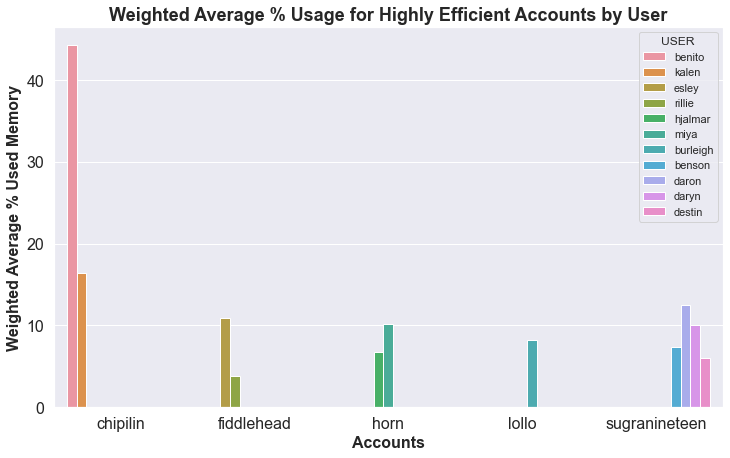

In [85]:
fontsize = 16

plt.figure(figsize = (12,7))
sns.barplot(x = 'ACCOUNT', y = '%USAGE', data = accre_users_hie, hue = 'USER')

plt.xticks(fontsize = fontsize)
plt.xlabel('Accounts', fontsize = fontsize, fontweight = 'bold')
plt.yticks(fontsize = fontsize)
plt.ylabel('Weighted Average % Used Memory', fontsize = fontsize, fontweight = 'bold')
plt.title('Weighted Average % Usage for Highly Efficient Accounts by User', fontsize = 18, fontweight = 'bold')
plt.legend(loc = 'upper right', fontsize = fontsize - 5);

plt.tight_layout() # removes extra margins around the edges
plt.savefig('weighted average for highly efficient accounts.png', dpi = 300); 

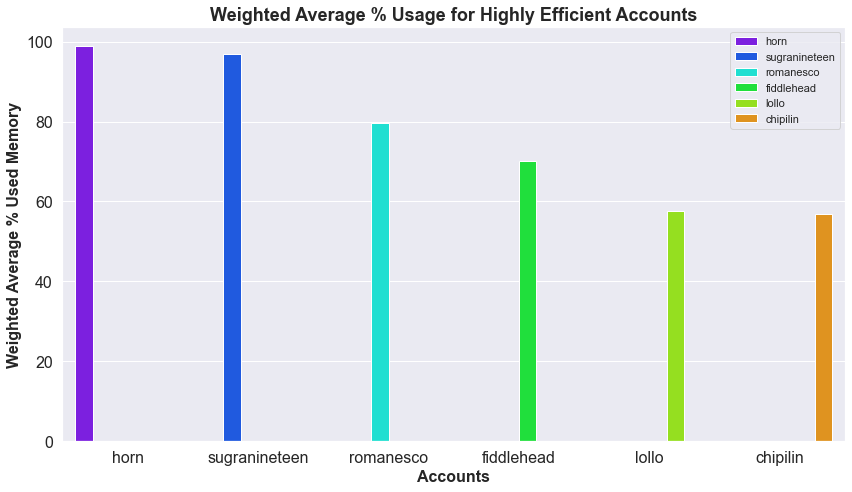

In [95]:
fontsize = 16

plt.figure(figsize = (12,7))
sns.barplot(x = 'ACCOUNT', y = '%USAGE', data = accre_acct_he, palette = 'gist_rainbow_r', hue='ACCOUNT')

plt.xticks(fontsize = fontsize)
plt.xlabel('Accounts', fontsize = fontsize, fontweight = 'bold')
plt.yticks(fontsize = fontsize)
plt.ylabel('Weighted Average % Used Memory', fontsize = fontsize, fontweight = 'bold')
plt.title('Weighted Average % Usage for Highly Efficient Accounts', fontsize = 18, fontweight = 'bold')
plt.legend(loc = 'upper right', fontsize = fontsize - 5);

plt.tight_layout() # removes extra margins around the edges
plt.savefig('weighted average for highly efficient accounts (no user info).png', dpi = 300); 